## Question: Forgetting about power laws, do eqns 17.x actually describe a well-defined distribution?



In [2]:
# bloody dependencies
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
from scipy.special import zeta, zetac
from scipy.optimize import fsolve

# custom classes
from legomena import Corpus, LogModel

### Choosing a Book

Select a book for use as our fitting corpus.

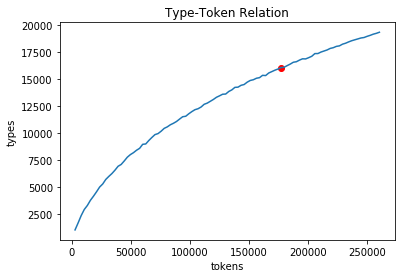

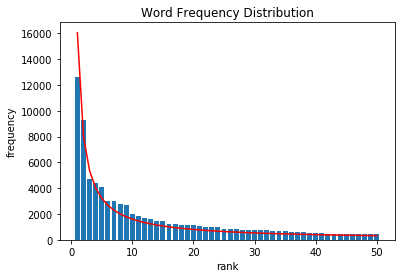

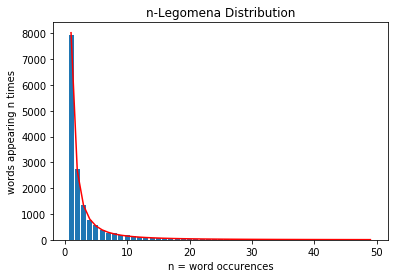

In [10]:
# # moby dick
# words = gutenberg.words("melville-moby_dick.txt")
# corpus = Corpus(words)
# corpus.dimension = 20
# TTR = corpus.TTR
# model = LogModel().fit(TTR.m_tokens, TTR.n_types)
# print("Optimum (M_z,N_z) =", model.params)

# plot TTR curve
plt.plot(TTR.m_tokens, TTR.n_types)
plt.scatter(*model.params, color="red")
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.show()

# take an optimum sample
optimum = corpus.sample(model.M_z)

# plot WFD
xmax = 50
H = np.sum(np.arange(xmax))
df = optimum.fdist.reset_index().head(xmax)
df["pred"] = optimum.N/df["rank"]
plt.bar(df["rank"], df["freq"])
plt.plot(df["rank"], df["pred"], color="red")
plt.title("Word Frequency Distribution")
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

# plot the k-vector
i = np.arange(1,50)
plt.bar(i, optimum.k[i])
plt.plot(i, optimum.N/i/(i+1), color = 'r')
plt.title("n-Legomena Distribution")
plt.xlabel("n = word occurences")
plt.ylabel("words appearing n times")
plt.show()

## The $n$-Legomena Curves

Each $n$-legomena model curve can be derived from the TTR curve, resulting in the following series of equations for ascending values of $n = 0, 1, 2, ...$. They are already "horizontally" normalized such that $x = m/M_z$ and $k_n$ gives the _count_ of the $n$th legomena. By "vertically" normalizing, setting $y(x) = E(x)/N_z, k'_n = k_n/N_z$ we'll obtain legomena _fractions_ rather than counts. Therefore, this series of equations answers the question "what fraction of types $k'_n$ do we expect to observe given $x$ fraction of tokens?"

$$
\begin{equation}
y(x) = \frac{\ln(x)x}{x-1} \tag{17}\label{eq:17}
\end{equation}
$$

$$
\begin{equation}
k'_0(x) = 1 - y(x) = \frac{x-\ln(x)x-1}{x-1} \tag{17.0}\label{eq:17.0}
\end{equation}
$$

$$
\begin{equation}
k'_1(x) = \frac{x^2-\ln(x)x-x}{(x-1)^2} \tag{17.1}\label{eq:17.1}
\end{equation}
$$

$$
\begin{equation}
k'_2(x) = \frac{x^3-2\ln(x)x^2-x}{2(x-1)^3} \tag{17.2}\label{eq:17.2}
\end{equation}
$$

$$
\begin{equation}
k'_3(x) = \frac{2x^4+3x^3-6\ln(x)x^3-6x^2+x}{6(x-1)^4} \tag{17.3}\label{eq:17.3}
\end{equation}
$$

$$
\begin{equation}
k'_4(x) = \frac{3x^5+10x^4-12x^4\ln(x)-18x^3+6x^2-x}{12(x-1)^5} \tag{17.4}\label{eq:17.4}
\end{equation}
$$

$$
\begin{equation}
k'_5(x) = \frac{12x^6+65x^5-60x^5\ln(x)-120x^4+60x^3-20x^2+3x}{60(x-1)^6} \tag{17.5}\label{eq:17.5}
\end{equation}
$$

We've already determined one useful ratio, the hapax ratio, in the original paper: $H(x) = \frac{k_1(x)}{E(x)} = \frac{k'_1(x)}{y(x)} = \frac{1}{\ln(x)}+\frac{1}{1-x}$. Let's exhaust some others...

## General Form

The ratio of $n$-legomena with respect to types as the corpus grows follows this beautiful and mysterious formula:

$$
y(x) = \phi\bigg(\frac{x-1}{x}, 1, 1\bigg) \\
\hat{k}_0(x) = 1 - y(x) = 1 - \phi\bigg(\frac{x-1}{x}, 1, 1\bigg) \\
\hat{k}_n(x) = (-1)^{n+1}\frac{x^n}{n!}y^{(n)}(x) = \frac{1}{n} - \frac{1}{x}\phi\bigg(\frac{x-1}{x}, 1, n+1\bigg)
$$

## Hypothesis

1. Since $k_n(1) = \frac{1}{n(n+1)} \approx n^{-2}$ by definition, the question then becomes: Does $k_n(x) \approx n^{\gamma(x)}$ for some function $\gamma(x)$, thus "imitating" a power law distribution?

2. Is this distribution already discovered, and if so, what is its name, history, and context? Might there be some dualism between text analytics and some other field?